## SPCS Final Project: Natural Disaster Detection for UAVs

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

!ls gdrive/MyDrive/disaster_dataset.zip
!unzip gdrive/MyDrive/disaster_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/Non_Damage_Wildlife_Forest/06_03_0701.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/Non_Damage_Wildlife_Forest/06_03_0702.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/Non_Damage_Wildlife_Forest/06_03_0703.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/Non_Damage_Wildlife_Forest/06_03_0704.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/Non_Damage_Wildlife_Forest/06_03_0705.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/Non_Damage_Wildlife_Forest/06_03_0706.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/Non_Damage_Wildlife_Forest/06_03_0707.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/Non_Damage_Wildlife_Forest/06_03_0708.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/Non_Damage_Wildlife_Forest/06_03_0709.png  
  inflating: 

In [2]:
import os
import shutil

base_dir='Comprehensive Disaster Dataset(CDD)'
output_dir='dataset'

category_map={
    "damaged":[
        'Damaged_Infrastructure/Earthquake',
    ],
    "fire":[
        "Fire_Disaster/Urban_Fire",
        "Fire_Disaster/Wild_Fire",
    ],
    "land":[
        "Land_Disaster/Land_Slide",
        "Land_Disaster/Drought",
    ],
    "water":[
        "Water_Disaster",
    ],
    "non_damage":[
        "Non_Damage/human",
        "Non_Damage/sea",
        "Non_Damage/Non_Damage_Buildings_Street",
        "Non_Damage/Non_Damage_Wildlife_Forest",
    ]
}
for category in category_map:
    os.makedirs(os.path.join(output_dir, category), exist_ok=True)

for category, folders in category_map.items():
    for folder in folders:
        folder_path = os.path.join(base_dir, folder)
        if os.path.exists(folder_path):
            for file_name in os.listdir(folder_path):
                src_file = os.path.join(folder_path, file_name)
                dst_file = os.path.join(output_dir, category, file_name)
                shutil.copy(src_file, dst_file)


In [3]:
import torch
# import torch.nn as nn
# import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import os
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])

In [4]:
import numpy as np
from collections import Counter

In [5]:
dataset=datasets.ImageFolder("dataset", transform=transform)
class_names= dataset.classes
num_classes = len(class_names)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_labels=[ dataset.targets[i] for i in train_dataset.indices]
class_counts= Counter(train_labels)
total_samples = sum(class_counts.values())

class_weights=[total_samples / class_counts[label] for label in range(num_classes)]
class_weights = np.array(class_weights, dtype=np.float32)
class_weights= class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if(device.type == 'cuda'):
    print("Using GPU for training")
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))


Using GPU for training


In [9]:
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(32 * 56 * 56, 128)
        self.fc2 = torch.nn.Linear(128, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)  # Dropout with a probability of 0.5
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = self.dropout(x)  # Apply dropout
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = SimpleCNN(num_classes).to(device)

In [8]:
from tqdm.auto import tqdm

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

history = {
    "train_loss": [],
    "val_loss": [],
    "val_accuracy": []
}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct=0
    total=0

    loop= tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_description(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%")
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = 100 * val_correct / val_total
        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_accuracy)

        print(f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%")


model_path = "simple_cnn.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Epoch 1/10:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch [1/10], Loss: 1.5091
Validation Loss: 1.1422, Validation Accuracy: 60.67%


Epoch 2/10:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.9741
Validation Loss: 1.0885, Validation Accuracy: 79.92%


Epoch 3/10:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.6827
Validation Loss: 0.9428, Validation Accuracy: 74.75%


Epoch 4/10:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.4645
Validation Loss: 1.0761, Validation Accuracy: 76.01%


Epoch 5/10:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.3108
Validation Loss: 1.2413, Validation Accuracy: 76.01%


Epoch 6/10:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.2159
Validation Loss: 1.3372, Validation Accuracy: 83.82%


Epoch 7/10:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.1684
Validation Loss: 1.8134, Validation Accuracy: 84.12%


Epoch 8/10:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.1648
Validation Loss: 1.3881, Validation Accuracy: 83.36%


Epoch 9/10:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.1369
Validation Loss: 1.7696, Validation Accuracy: 83.57%


Epoch 10/10:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.1554
Validation Loss: 1.9613, Validation Accuracy: 85.00%
Model saved to simple_cnn.pth


In [11]:
history

{'train_loss': [1.509071688312371,
  0.9740912678187122,
  0.6826798423144667,
  0.46450832742281034,
  0.3108086426622804,
  0.21593342739936058,
  0.16843137769394498,
  0.16482827267534192,
  0.13694637277940286,
  0.1553690024088175],
 'val_loss': [1.1422405920108827,
  1.0885479969136855,
  0.9428384380180295,
  1.076073118818908,
  1.241291177773676,
  1.3372311086213888,
  1.813370633325657,
  1.388096069337941,
  1.7696018499987467,
  1.9612700659687778],
 'val_accuracy': [60.67226890756302,
  79.91596638655462,
  74.74789915966386,
  76.00840336134453,
  76.00840336134453,
  83.82352941176471,
  84.11764705882354,
  83.36134453781513,
  83.57142857142857,
  85.0]}

In [12]:
#test the model
model.eval()
import torch
import torchvision.transforms as transforms
from torchvision import datasets

def predict_image(image_path, model, transform):
    image = datasets.folder.default_loader(image_path)
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    return class_names[predicted.item()]


image_path = "testphto.jpg"
predicted_class = predict_image(image_path, model, transform)
print(f"Predicted class: {predicted_class}")

FileNotFoundError: [Errno 2] No such file or directory: 'testphto.jpg'

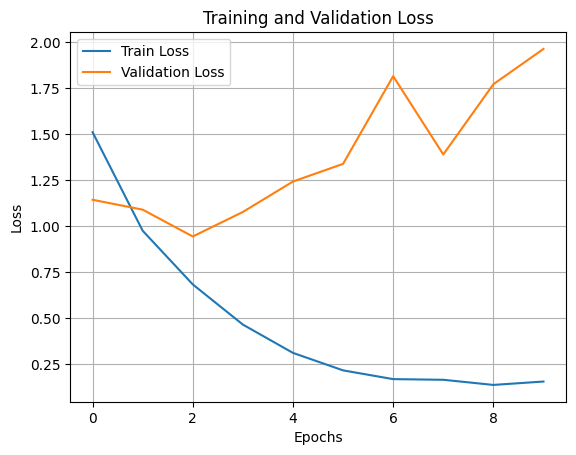

In [13]:
import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

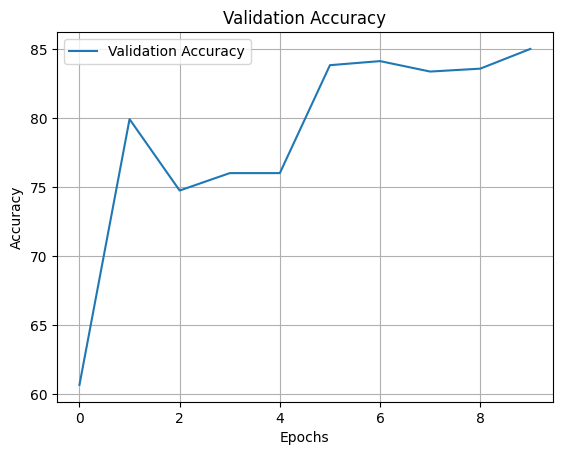

In [14]:
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [16]:
def plot_confustion_matrix(model,dataloader,class_names,title="Confusion Matrix"):

    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

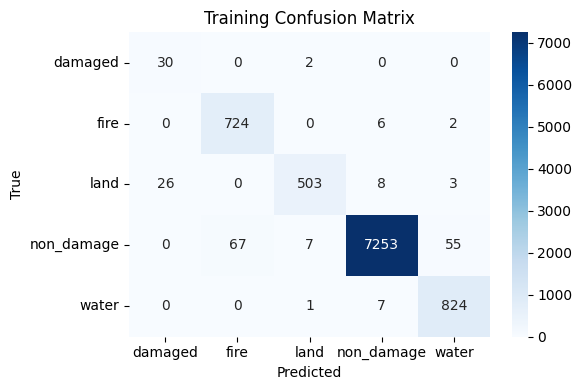

In [17]:
plot_confustion_matrix(model, train_loader, class_names, title="Training Confusion Matrix")

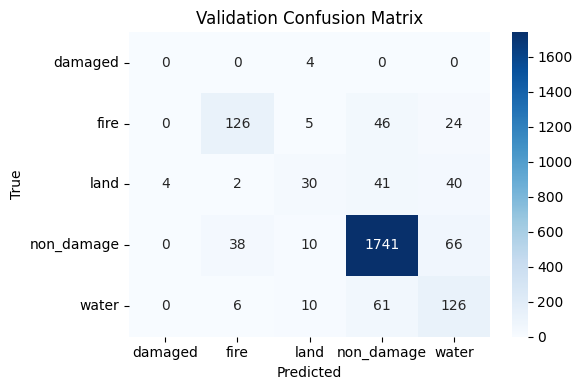

In [18]:
plot_confustion_matrix(model, val_loader, class_names, title="Validation Confusion Matrix")